# Using celloracle to perform perturbation prediction

## use celloracle perturbation prediction to predict TF perturbation effects

## Library imports

In [1]:
import celloracle as co
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module

/home/icb/weixu.wang/miniconda3/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/icb/weixu.wang/miniconda3/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobi

In [2]:
import os
import sys

import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import scanpy as sc
from scvelo import logging as logg

import os,sys
sys.path.append("../..")
from paths import FIG_DIR, DATA_DIR

[rank: 0] Global seed set to 0


## General settings

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'zebrafish' / 'celloracle' ,exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'zebrafish' / 'celloracle' ,exist_ok = True)

## Function definations

In [5]:
def split_elements(character_list):
    result_list = []
    for element in character_list:
        if '_' in element:
            parts = element.split('_')
            result_list.append(parts)
        else:
            result_list.append([element])
    return result_list

def combine_elements(split_list):
    result_list = []
    for parts in split_list:
        combined_element = "_".join(parts)
        result_list.append(combined_element)
    return result_list

def pipeline(gene_for_KO):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={gene_for_KO: 0},
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)
    
    ## calculate overall score
    dev = Oracle_development_module()
    # Load development flow
    dev.load_differentiation_reference_data(gradient_object=gradient)
    # Load simulation result
    dev.load_perturb_simulation_data(oracle_object=oracle, n_neighbors = n_neighbors)
    # Calculate inner product
    dev.calculate_inner_product()
    dev.calculate_digitized_ip(n_bins=10)

    # Save results in a hdf5 file.
    ps_max = dev.get_negative_PS_p_value(return_ps_sum=True, plot=False)[1]
        
    # Do simulation for all conditions.
    Lineage = []
    PS_score = []
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name, n_neighbors = n_neighbors)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        ps = dev.get_negative_PS_p_value(return_ps_sum=True, plot=False)[1]
        ps = ps / ps_max
        Lineage.append(lineage_name)
        PS_score.append(ps)
    
    df = pd.DataFrame({"Lineage": Lineage,
                   "PS_score":PS_score})
    df.index = Lineage
    
    return df

def pipeline2(gene_for_KO):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={key: 0 for key in gene_for_KO},
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)
    
    ## calculate overall score
    dev = Oracle_development_module()
    # Load development flow
    dev.load_differentiation_reference_data(gradient_object=gradient)
    # Load simulation result
    dev.load_perturb_simulation_data(oracle_object=oracle, n_neighbors = n_neighbors)
    # Calculate inner product
    dev.calculate_inner_product()
    dev.calculate_digitized_ip(n_bins=10)

    # Save results in a hdf5 file.
    ps_max = dev.get_negative_PS_p_value(return_ps_sum=True, plot=False)[1]
        
    # Do simulation for all conditions.
    Lineage = []
    PS_score = []
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name, n_neighbors = n_neighbors)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        ps = dev.get_negative_PS_p_value(return_ps_sum=True, plot=False)[1]
        ps = ps / ps_max
        Lineage.append(lineage_name)
        PS_score.append(ps)
    
    df = pd.DataFrame({"Lineage": Lineage,
                   "PS_score":PS_score})
    df.index = Lineage
    
    return df

def TFScanning_perturbation(adata, n_states, cluster_label, terminal_states, TF):
    #TF = adata.var.index[weight != 0].tolist()
    
    coef = []
    for tf in TF:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline(tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+tf)
    d = {'TF': TF, 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

def Multiple_TFScanning_perturbation(data, n_states, cluster_label, terminal_states, TF_pair):
    #TF = adata.var.index[weight != 0].tolist()
    
    coef = []
    for tf in TF_pair:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline2(tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+combine_elements([tf])[0])
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

def get_list_name(lst):
    names = []
    for name, obj in lst.items():
        names.append(name)
    return names

## Data loadings

In [6]:
adata = sc.read_h5ad("RegVelo_datasets/zebrafish/adata_zebrafish_preprocessed.h5ad")
perturbation = pd.read_csv("RegVelo_datasets/zebrafish/df_median_meld_likelihood.csv")
df = pd.read_csv("RegVelo_datasets/zebrafish/eRegulon_metadata_all.csv",index_col = 0)

In [7]:
df.loc[:,"Target"] = [f"{a}*{b}" for a, b in zip(df.loc[:,"Region"].tolist(), df.loc[:,"Gene"].tolist())]
df = df.loc[:,["TF","Gene","Target"]]

In [8]:
regulators = df['TF'].unique()
targets = df['Target'].unique()

# Create an empty binary matrix
binary_matrix = pd.DataFrame(0, columns=regulators, index=targets)

# Fill the binary matrix based on the relationships in the CSV file
for index, row in df.iterrows():
    binary_matrix.at[row['Target'], row['TF']] = 1

original_list = binary_matrix.index.tolist()
peak = [item.split('*')[0] for item in original_list]
target = [item.split('*')[1] for item in original_list]

binary_matrix.loc[:,"peak_id"] = peak
binary_matrix.loc[:,"gene_short_name"] = target

binary_matrix = binary_matrix[['peak_id', 'gene_short_name'] + [col for col in binary_matrix if col not in ['peak_id', 'gene_short_name']]]
binary_matrix = binary_matrix.reset_index(drop=True)

In [9]:
scv.pp.moments(adata, n_pcs=50, n_neighbors=30)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [11]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/112 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


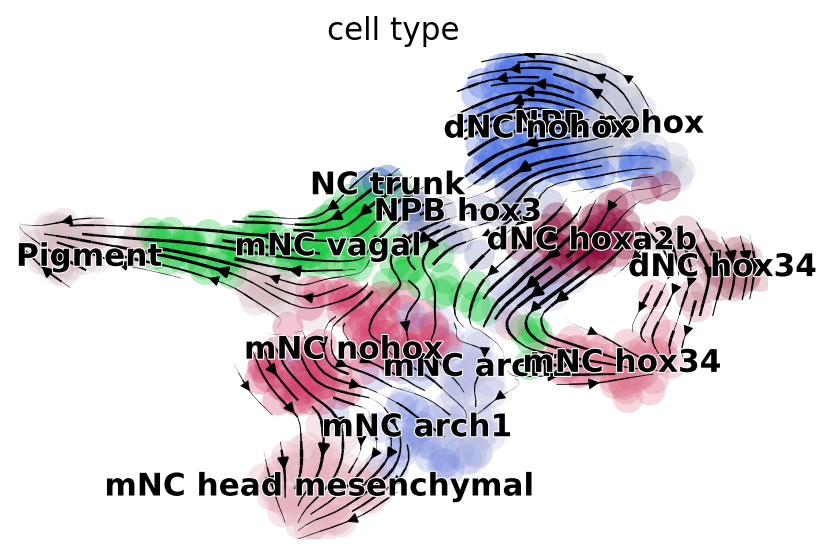

In [12]:
scv.pl.velocity_embedding_stream(adata, color = 'cell_type',basis = "umap")

In [13]:
adata.X = adata.layers["matrix"].copy()
oracle = co.Oracle()
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cell_type",
                                   embedding_name="X_umap")

oracle.import_TF_data(TF_info_matrix=binary_matrix)

8012 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


In [14]:
oracle.perform_PCA()

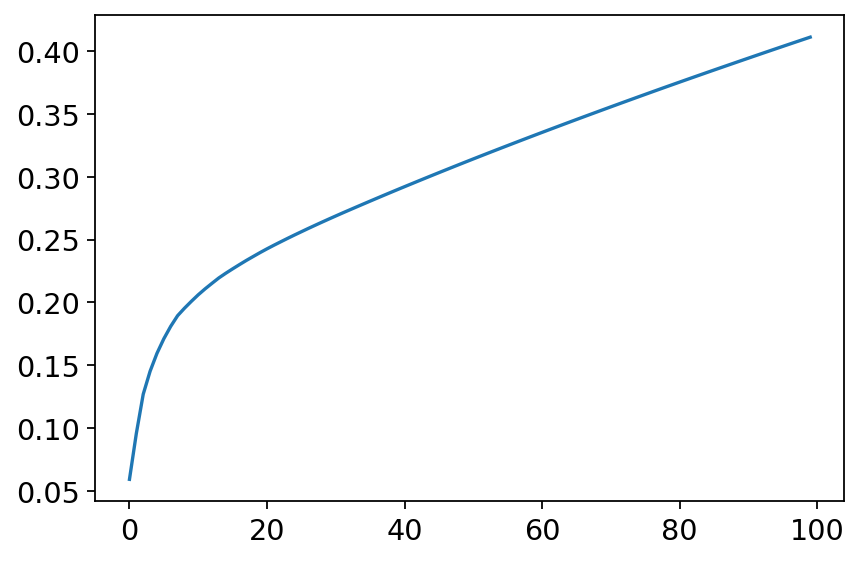

In [15]:
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])

In [16]:
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]

In [17]:
n_comps = min(n_comps, 50)

In [18]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :697
Auto-selected k is :17


In [19]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [20]:
links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10,
                         verbose_level=10)

  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for NC_trunk...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for NPB_hox3...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for NPB_nohox...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for Pigment...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for dNC_hox34...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for dNC_hoxa2b...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for dNC_nohox...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_arch1...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_arch2...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_head_mesenchymal...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_hox34...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_nohox...


  0%|          | 0/1925 [00:00<?, ?it/s]

Inferring GRN for mNC_vagal...


  0%|          | 0/1925 [00:00<?, ?it/s]

In [21]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()

In [22]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/13 [00:00<?, ?it/s]

## Perturb mitfa as example

In [23]:
goi = "mitfa"
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [24]:
oracle.estimate_transition_prob(n_neighbors=30,
                                knn_random=True,
                                sampled_fraction=1)
oracle.calculate_embedding_shift(sigma_corr=0.05)

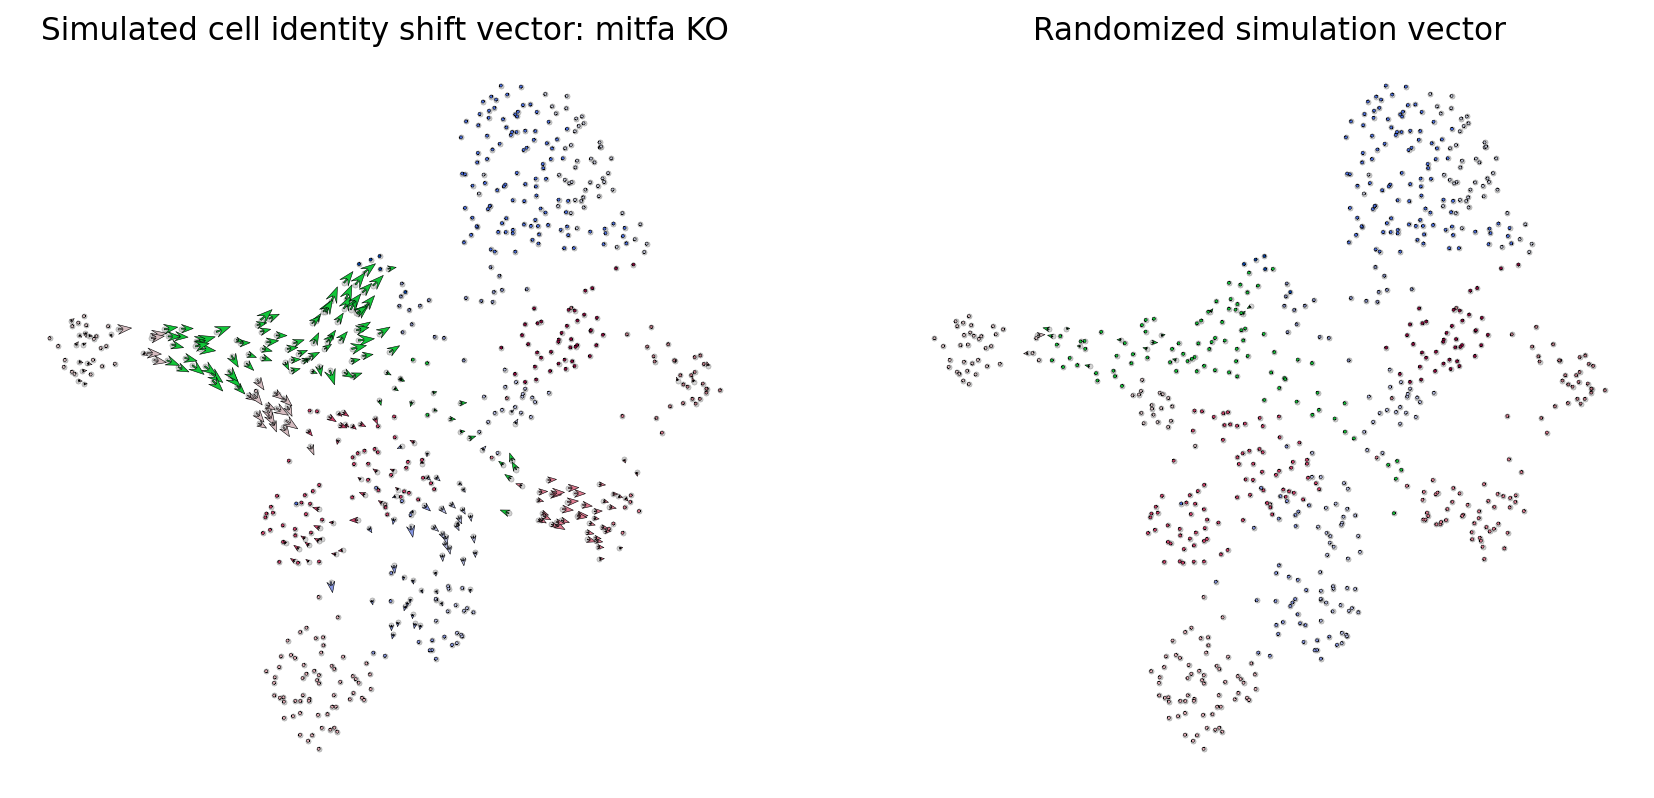

In [25]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
scale = 50
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

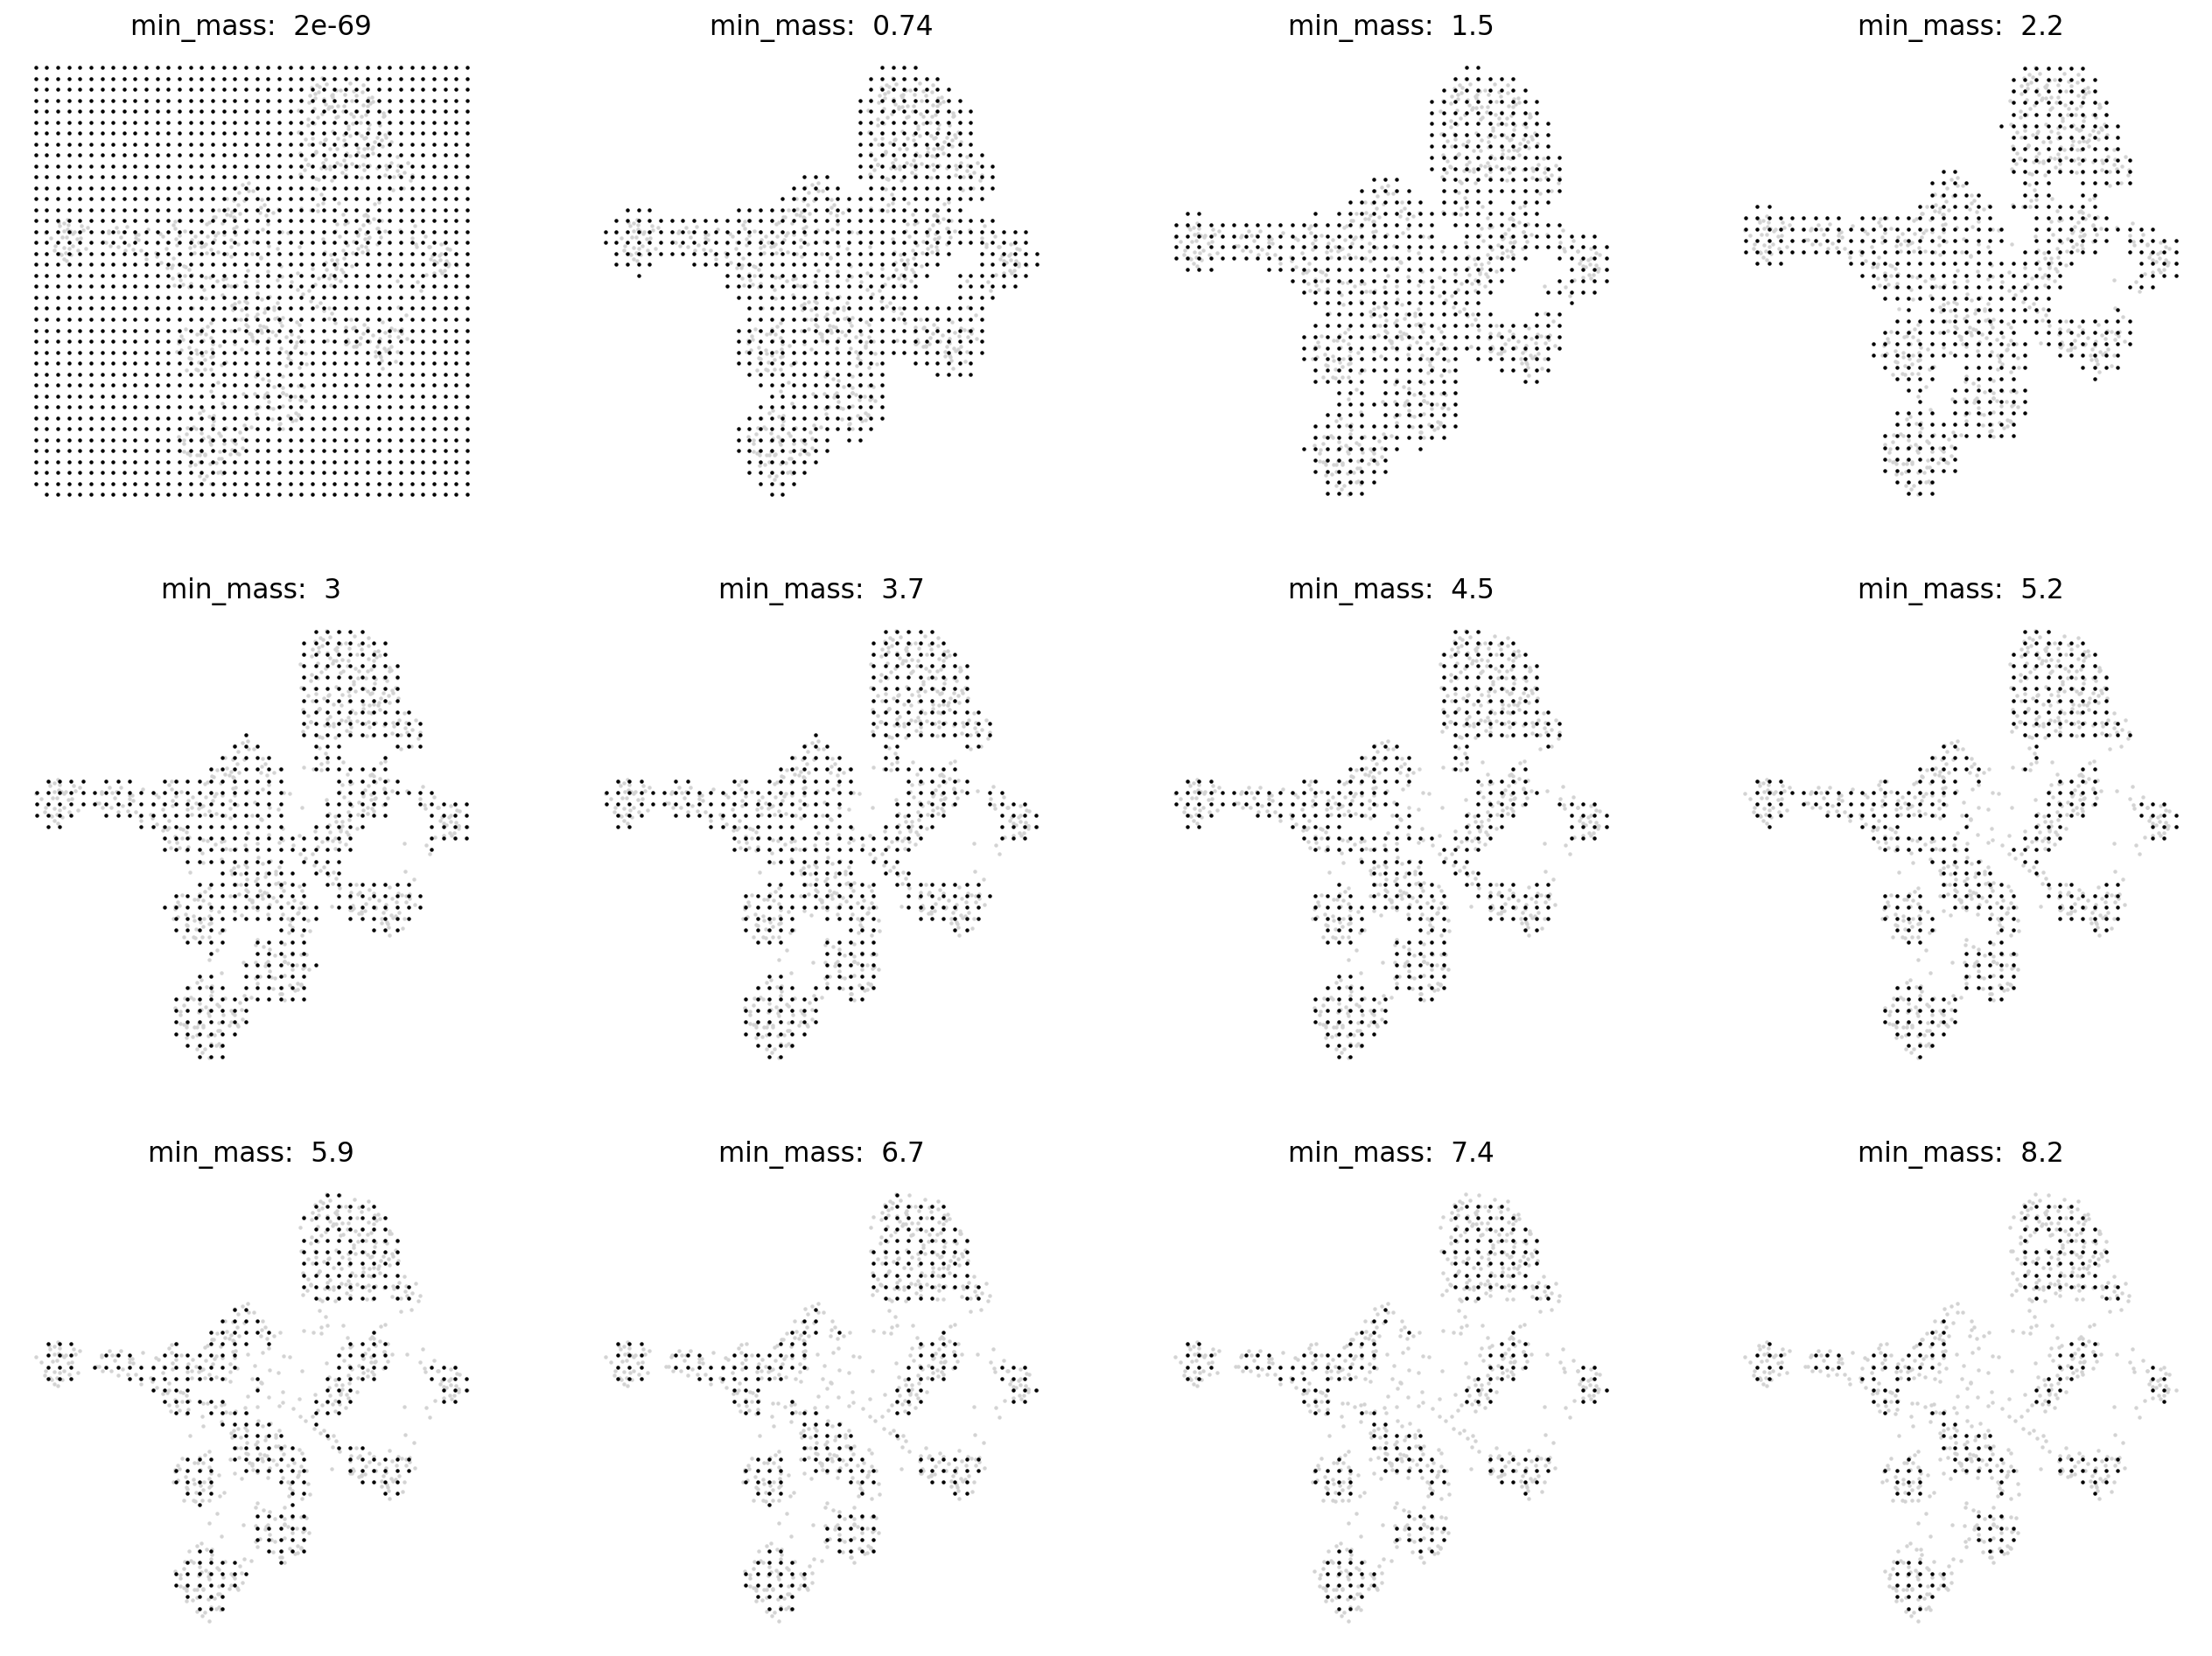

In [26]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=30)
oracle.suggest_mass_thresholds(n_suggestion=12)

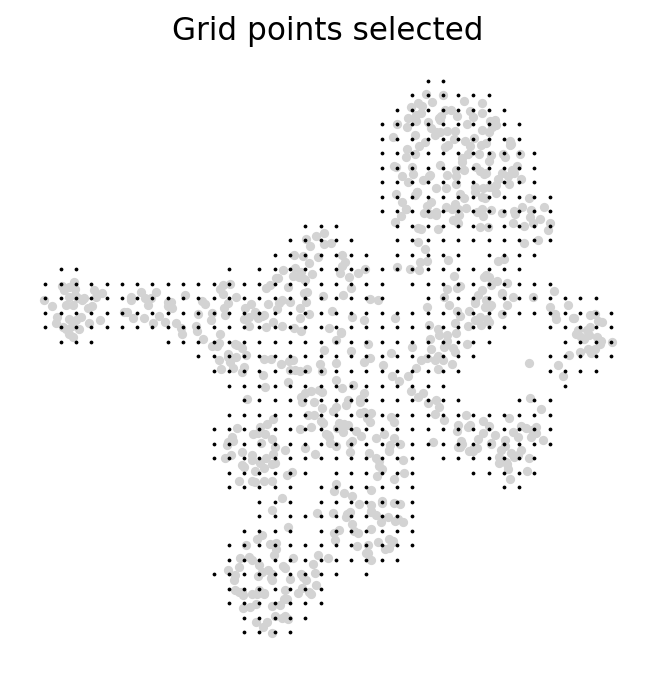

In [27]:
min_mass = 1.5
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

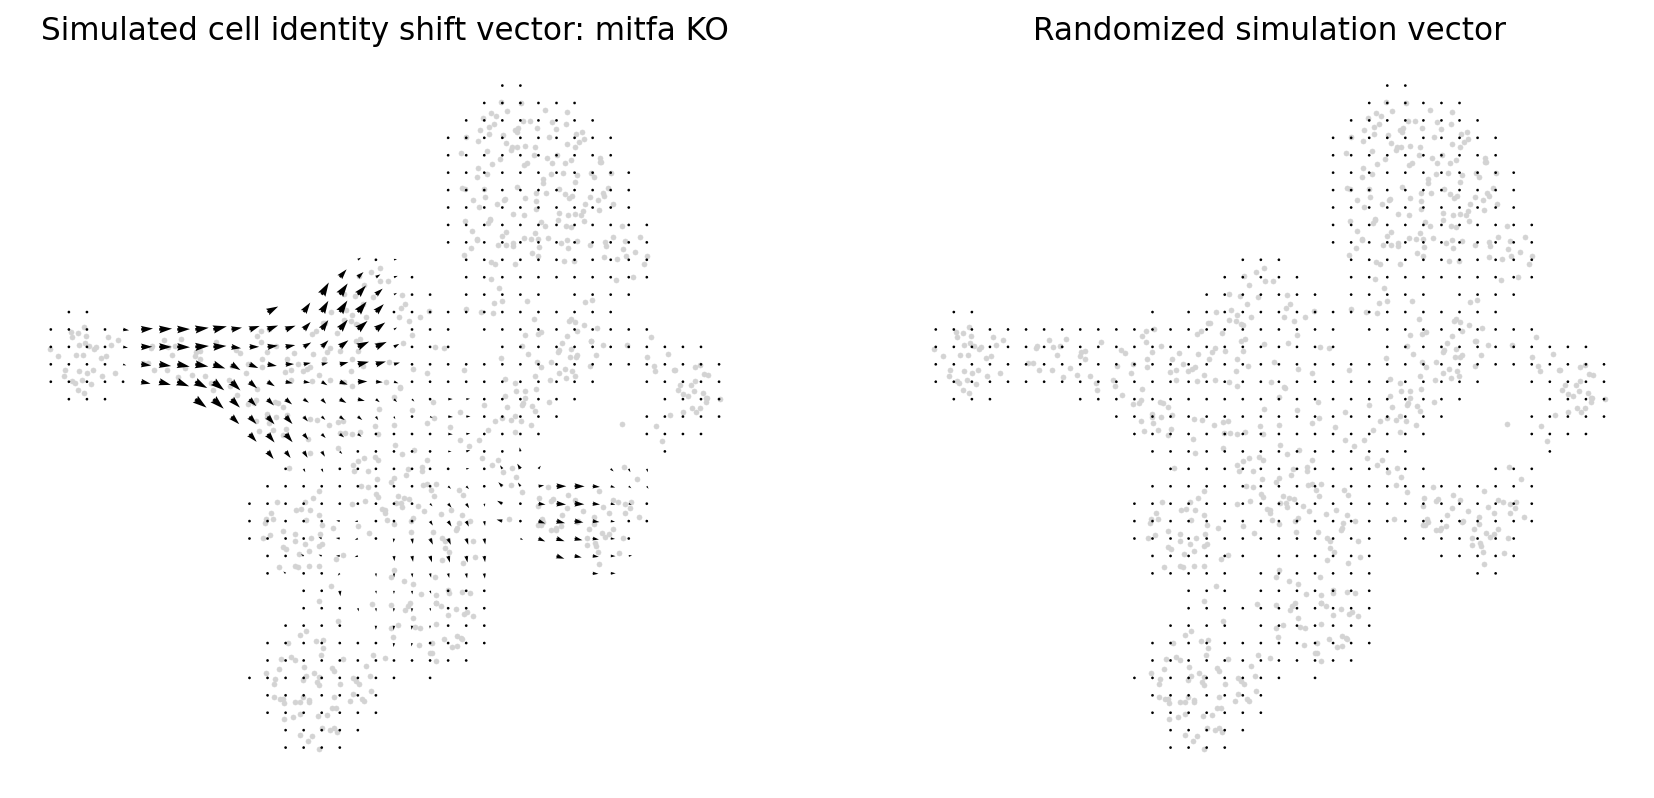

In [28]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 50
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## Define reference vector field

In [29]:
## calculate pseudotime
scv.tl.recover_dynamics(
        adata, var_names=adata.var_names, n_jobs=4
    )
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata,min_likelihood=None)

recovering dynamics (using 4/112 cores)


  0%|          | 0/8012 [00:00<?, ?gene/s]

[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0


    finished (0:05:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


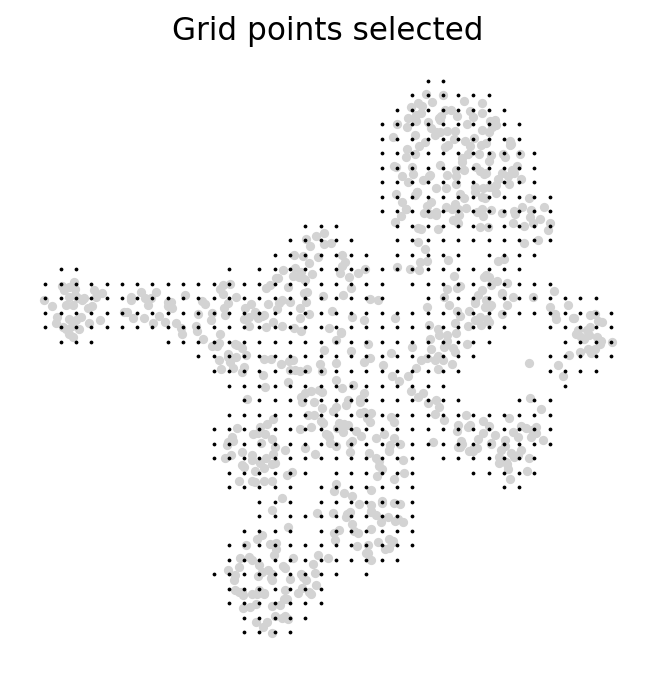

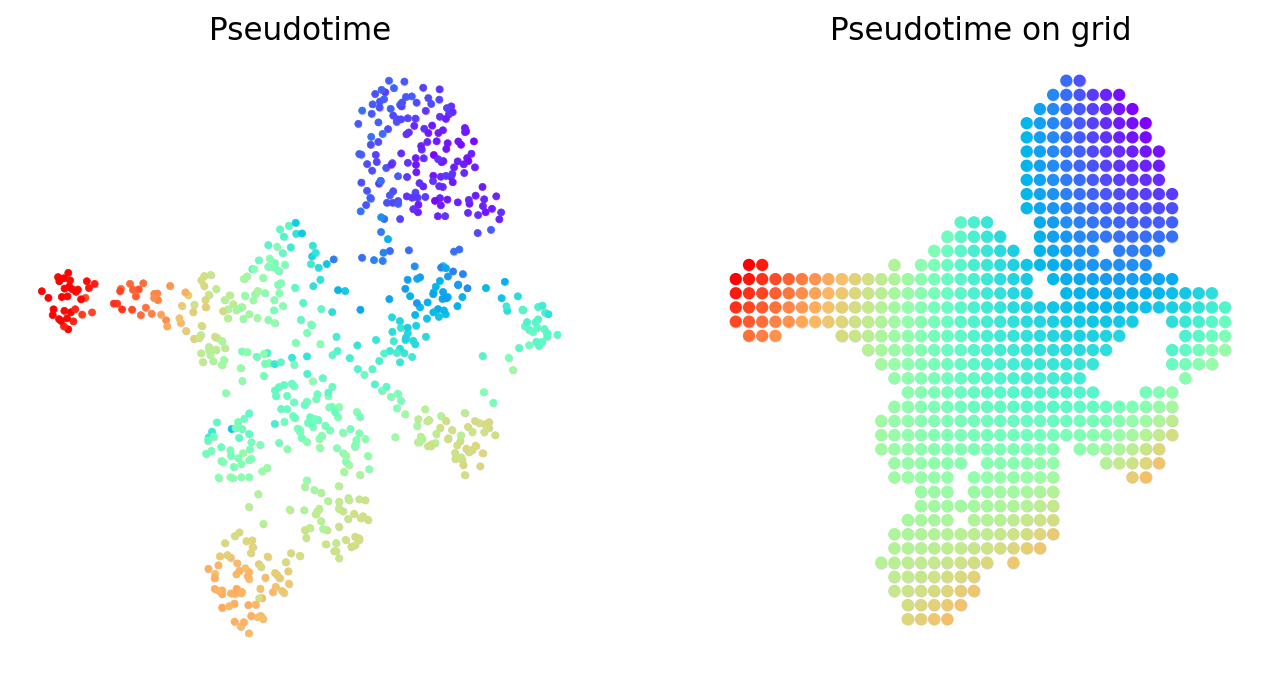

In [30]:
## use the velocity latent time inferred by scVelo to create gradient field
n_grid = 40
min_mass = 1.5
oracle.adata.obs["Pseudotime"] = adata.obs["latent_time"].copy()
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=30)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)
gradient.calculate_gradient()

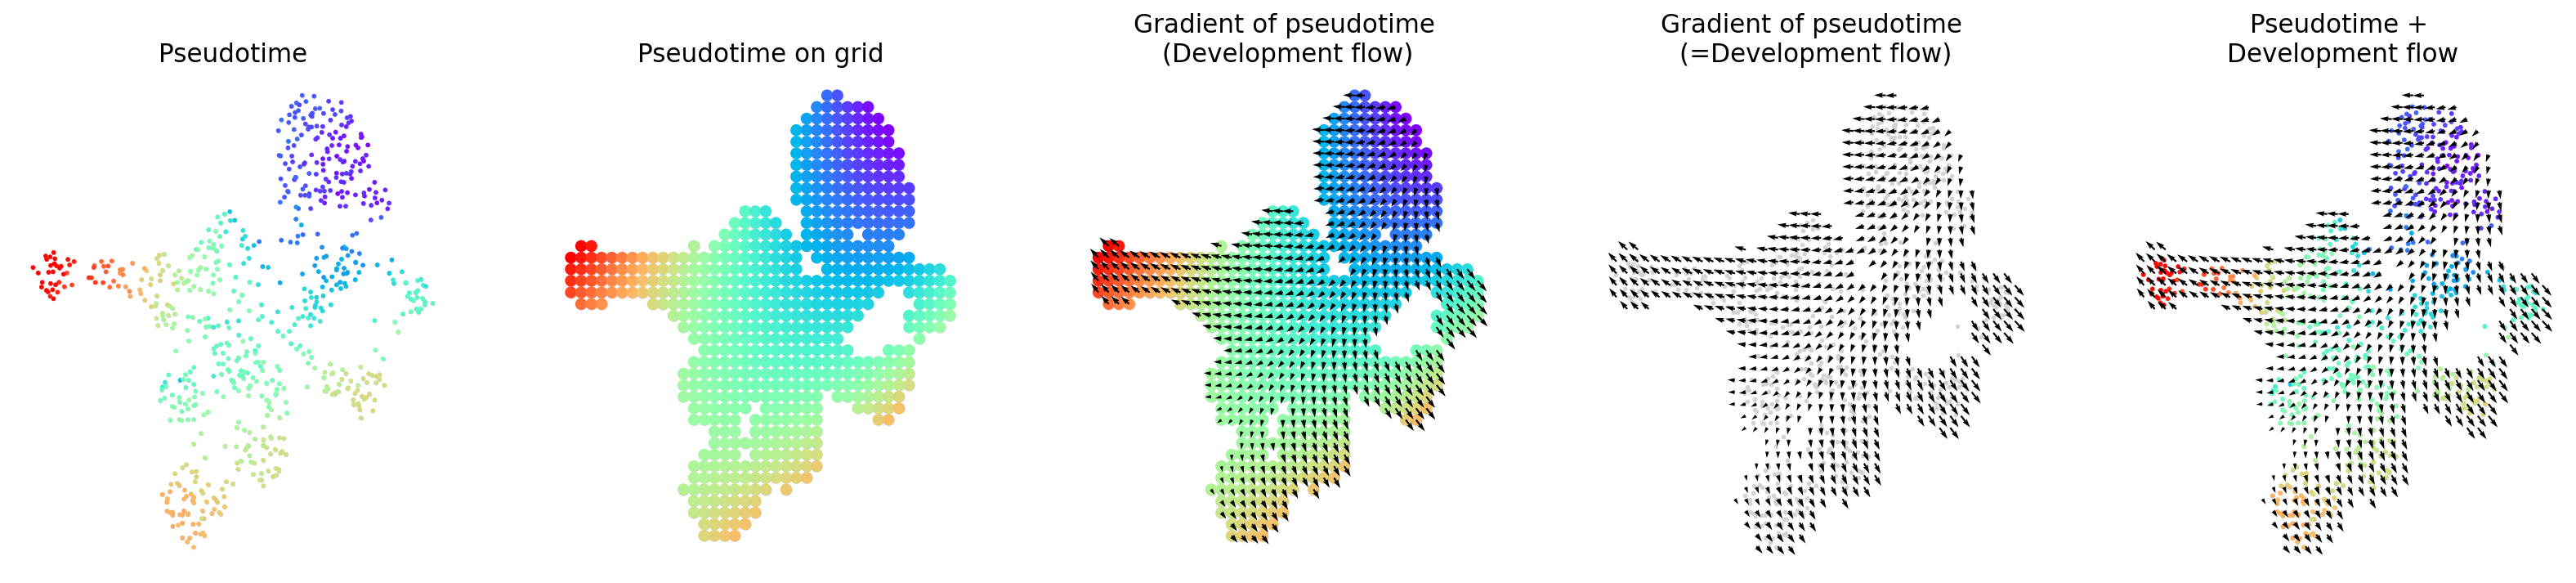

In [31]:
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

In [32]:
cell_idx_pigment = np.where(oracle.adata.obs["cell_type"].isin([
    'Pigment']))[0]

cell_idx_hox34 = np.where(oracle.adata.obs["cell_type"].isin([
    'mNC_hox34']))[0]

cell_idx_arch2 = np.where(oracle.adata.obs["cell_type"].isin([
    'mNC_arch2']))[0]

cell_idx_mesenchymal = np.where(oracle.adata.obs["cell_type"].isin([
    'mNC_head_mesenchymal']))[0]

In [33]:
index_dictionary = {"Pigment": cell_idx_pigment,
                    "mNC_hox34": cell_idx_hox34,
                    "mNC_arch2": cell_idx_arch2,
                    "mNC_head_mesenchymal": cell_idx_mesenchymal}

In [34]:
n_propagation = 3
n_neighbors=30

In [35]:
gene_list = ['elk3',
 'erf',
 'fli1a',
 'mitfa',
 'nr2f5',
 'rarga',
 'rxraa',
 'smarcc1a',
 'tfec']

In [36]:
gene_list = set(gene_list).intersection(adata.var_names)
gene_list = list(gene_list)
len(gene_list)

8

In [37]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

In [38]:
d2 = TFScanning_perturbation(adata,8,"cell_type",terminal_states,gene_list)

Done tfec
Done elk3
Done mitfa
Done nr2f5
Done fli1a
Done rarga
Done erf
Done rxraa


In [39]:
coef = pd.DataFrame(np.array(d2['coefficient']))
coef.index = d2['TF']
coef.columns = get_list_name(d2['coefficient'][0])

In [40]:
coef = coef.loc[gene_list,:]

In [41]:
## read the perturbation results and perform benchmark
gt = perturbation.copy()
gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]

In [42]:
for tf in gene_list:
    gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])

In [43]:
terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
coef = coef.loc[:,terminal_states]
coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]

In [44]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (-coef.loc[tf,ts]+1)/2
    #effect = np.log(coef_aggregate.loc[tf,ts])
    #effect = effect / effect.sum()
    pred_effect.append(effect)
    TF.append(tf)

In [45]:
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.0018362131579837673, pvalue=0.9920420996003623)

In [46]:
multiple_ko = ["fli1a_elk3","mitfa_tfec","tfec_mitfa_bhlhe40","fli1a_erf_erfl3","erf_erfl3"]
multiple_ko_list = split_elements(multiple_ko)

In [47]:
d2 = Multiple_TFScanning_perturbation(adata,8,"cell_type",terminal_states,multiple_ko_list)

Done fli1a_elk3
Done mitfa_tfec
Done tfec_mitfa_bhlhe40
Done fli1a_erf_erfl3
Done erf_erfl3


In [48]:
coef = pd.DataFrame(np.array(d2['coefficient']))
coef.index = d2['TF']
coef.columns = get_list_name(d2['coefficient'][0])

In [49]:
## read the perturbation results and perform benchmark
gt = perturbation.copy()
gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]

In [50]:
for tf in coef.index:
    gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])

In [51]:
terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
coef = coef.loc[:,terminal_states]
coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]

In [52]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (-coef.loc[tf,ts]+1)/2
    #effect = np.log(coef_aggregate.loc[tf,ts])
    #effect = effect / effect.sum()
    pred_effect.append(effect)
    TF.append(tf)

In [53]:
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.10993988371401199, pvalue=0.6445037279109584)